<!-- Simon-Style -->
<p style="font-size:19px; text-align:left; margin-top:    15px;"><i>German Association of Actuaries (DAV) — Working Group "Explainable Artificial Intelligence"</i></p>
<p style="font-size:25px; text-align:left; margin-bottom: 15px"><b>Use Case SOA GLTD Experience Study:<br>
Gradient Boosted Tree - Predictive Performance
</b></p>
<p style="font-size:19px; text-align:left; margin-bottom: 15px; margin-bottom: 15px">Guido Grützner (<a href="mailto:guido.gruetzner@quantakt.com">guido.gruetzner@quantakt.com</a>)

# Introduction

Gradient boosted trees are fitted, and their predictive performance is evaluated.

The used hyperparameters have been established in the notebook "hptuning_boost.ipynb". Three variants are compared: A model "no_interactions" without interactions, i.e. an additive model, a model "pairwise" with only pairwise interactions, and a model "None" without constraints on the type and size of interactions.

This notebook takes about 25 min to run with the given parameters and `pct=0.3`.

# Initialisation

In [1]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
# adjust according to your age and vision
plt.rcParams['axes.titlesize'] = 20   # Title font size
plt.rcParams['axes.labelsize'] = 15   # Axis label font size
plt.rcParams['xtick.labelsize'] = 12  # X-axis tick label font size
plt.rcParams['ytick.labelsize'] = 12  # Y-axis tick label font size 

import gltd_utilities

import time
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True

# adjust accordingly, more CPUs is faster but then script may block PC
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

* Adapt the path for the data file in the call of `load_gltd_data`, if necessary.
* Adapt pct to your requirements for anything between  $0.05\leq pct\leq1$. 
* Input 1 uses all data available, lower numbers the respective fraction. Below 0.05 predictions become somewhat volatile.

In [2]:
tic = time.time()
(X, Y, ID, nm_cat, nm_num, seed, rng) = gltd_utilities.load_gltd_data(
                                            "./", pct=0.3)
seed

'190926317337784452451646965445424039034'

# Evaluate

In [3]:
# number and size of bootstrap iterations
gss = GroupShuffleSplit(n_splits=6, train_size=0.7, test_size=0.3,
                        random_state=rng.integers(low=0, high=1000))

# Interaction constraint
md_inter_list = [None, "pairwise", "no_interactions"]

# container for results
typelist = list()
lltrainlist = list()
lltestlist = list()

for md_inter in md_inter_list:
    print("--------------------------------------------")
    print(md_inter)
    print("--------------------------------------------")

    for ii, (trainidx, testidx) in enumerate(gss.split(X,groups=ID)):
        
        print(f"Run {ii + 1}:")

        xtrain, xtest = X.iloc[trainidx, :], X.iloc[testidx, :]
        ytrain, ytest = Y.iloc[trainidx], Y.iloc[testidx]
        
        md = HistGradientBoostingClassifier(
                interaction_cst = md_inter,
                categorical_features="from_dtype",
                max_iter=1000,
                learning_rate=0.02,
                max_leaf_nodes=80,
                random_state=rng.integers(low=0, high=1000))

        md.fit(xtrain, ytrain)

        # performance statistics
        phat = {"train": md.predict_proba(xtrain), 
                "test": md.predict_proba(xtest)}
        typelist = typelist + [md_inter]
        lltrainlist = (lltrainlist 
                        + [log_loss(ytrain, phat["train"])])
        lltestlist = (lltestlist 
                        + [log_loss(ytest, phat["test"])])

        


--------------------------------------------
None
--------------------------------------------
Run 1:
Run 2:
Run 3:
Run 4:
Run 5:
Run 6:
--------------------------------------------
pairwise
--------------------------------------------
Run 1:
Run 2:
Run 3:
Run 4:
Run 5:
Run 6:
--------------------------------------------
no_interactions
--------------------------------------------
Run 1:
Run 2:
Run 3:
Run 4:
Run 5:
Run 6:


In [4]:
# remember: row-major!
lltrainarr = (100**2 
              * np.array(lltrainlist).reshape(len(md_inter_list), gss.get_n_splits()) )
lltestarr = (100**2 
             * np.array(lltestlist).reshape(len(md_inter_list), gss.get_n_splits()))

## Analysis

To enhance readability, log-loss is reported in bps (basis points), i.e. multiplied by 10'000 and rounded.

In [5]:
resdf = pd.DataFrame(
    {"model": ["all", "pairwise", "no_interactions"],
    "train mean": np.mean(lltrainarr, axis=1), 
    "train stdev": np.std(lltrainarr, axis=1),
    "test mean": np.mean(lltestarr, axis=1),
    "test stdev": np.std(lltestarr, axis=1)}
)
tmpdf = resdf.select_dtypes(include=['number'])
resdf[tmpdf.columns] = tmpdf.apply(lambda x: round(x,0)).astype("int")
resdf.sort_values(["test mean"], ascending=False)

,model,train mean,train stdev,test mean,test stdev
2,no_interactions,542,2,544,5
1,pairwise,507,2,524,5
0,all,471,7,520,4


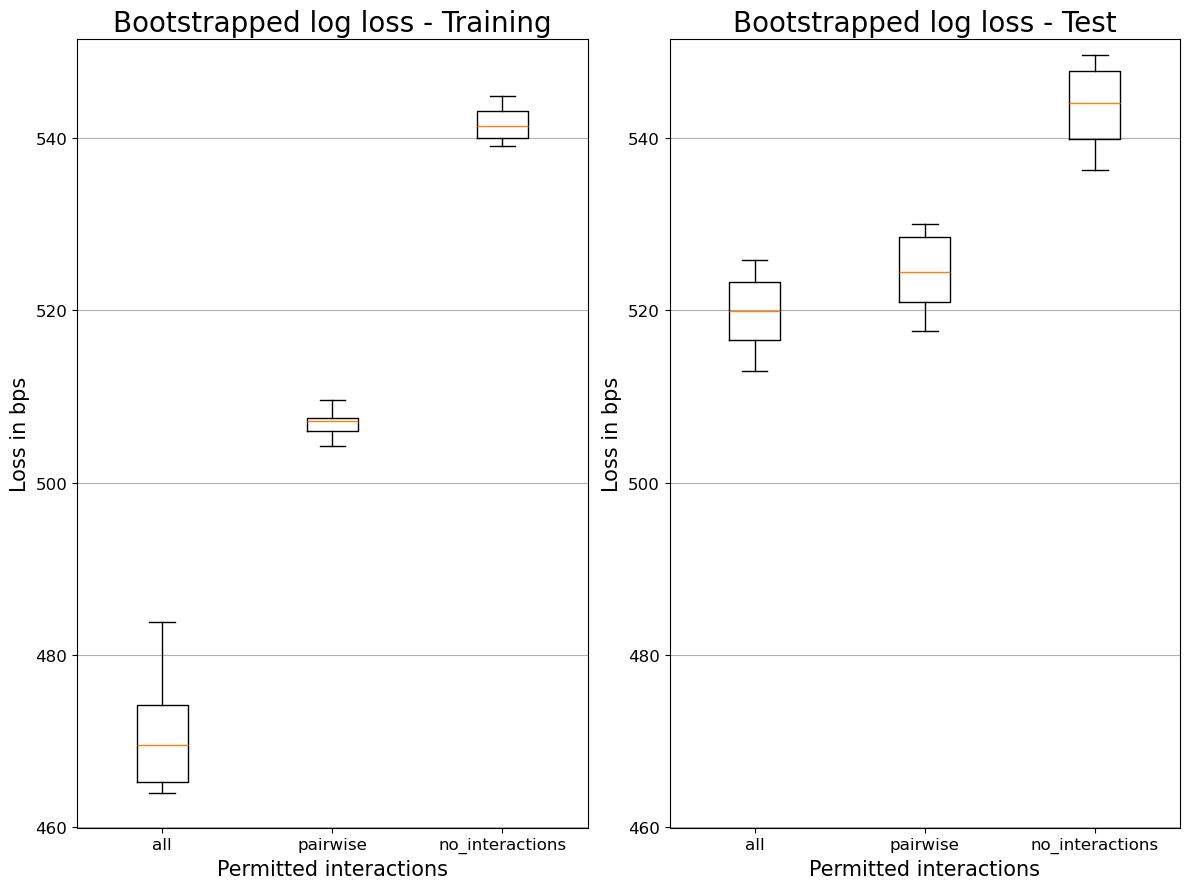

In [6]:
pltdf = pd.DataFrame(lltestarr,
        index=md_inter_list,
        columns= [str(iter) for iter in range(1, gss.get_n_splits()+1)]).T

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,9))
tt = ["all"] + pltdf.columns.values.tolist()[1:]

pltdf = pd.DataFrame(lltrainarr,
        index=md_inter_list,
        columns= [str(iter) for iter in range(1, gss.get_n_splits()+1)]).T

ax[0].boxplot(pltdf, tick_labels=tt)
ax[0].grid(which="major", axis="y")
ax[0].set_xlabel("Permitted interactions")
ax[0].set_title("Bootstrapped log loss - Training")

pltdf = pd.DataFrame(lltestarr,
        index=md_inter_list,
        columns= [str(iter) for iter in range(1, gss.get_n_splits()+1)]).T

ax[1].boxplot(pltdf, tick_labels=tt)
ax[1].grid(which="major", axis="y")
ax[1].set_xlabel("Permitted interactions")
ax[1].set_title("Bootstrapped log loss - Test")

# Determine the common y-axis limit
y_max = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
y_min = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0])

# Set the same y-axis limit for both plots
ax[0].set_ylim([y_min, y_max])
ax[0].set_ylabel("Loss in bps")
ax[1].set_ylim([y_min, y_max])
ax[1].set_ylabel("Loss in bps")
# Adjust layout
plt.tight_layout()

Observations:
* Interactions make a difference. To get a feeling for the size of the difference, compare the 20bps between "no_interactions" and "pairwise" for Test with typical numbers from the drop1 explanation in the notebook "exp_drop1". 20bps difference is about the difference between having or not having an important input, i.e. it is really significant.
* There is much less difference, if any, between "pairwise" and "all".

In [7]:
print(f"Time it took: {np.ceil((time.time() - tic)/60)}min.")

Time it took: 36.0min.
